# SoundScapify - Song Recommender based on Soundscape (Part 1 of 4)

For this project, this is the first notebook, we will have 4 parts of notebook as follows:  
1. **Introduction and Train Dataset EDA**
2. Model Training
3. Model Prediction with Test Dataset
4. Song Dataset Retrieval

## Introduction

### Background

Music has been along our side throughout our life. When we are babies, our parents would sing lullabies at night to make us asleep. When we are students, music accompaniments help us go through vicious cycles of exams and projects. Even as an adult, music help us go through a lot when we are bored, happy, sad or angry. Therefore, music plays a major role in our livelihood.

In a [survey](https://www.plansponsor.com/SURVEY-SAYS-How-You-Spend-Your-Commute/?layout=print) back in 2015, almost half of the respondents listen to music during their commute. In Singapore alone, 40% of Singaporeans listen to music during their commute according to NAC [survey.](https://www.nac.gov.sg/about-us/media-centre/press-releases/singaporeans-are-avid-music-listeners-says-first-national-music-consumption-survey)
This also elevated the reason due to a [study](https://www.cell.com/trends/cognitive-sciences/fulltext/S1364-6613(13)00049-1) that revealed music helps to reduce stress and improve our overall well being. 

Therefore it is important have songs that fit with the ambience of our commute in general. 

### Problem Statement

Based on the information above, the project aims to build a **song recommender** based on the **current ambience and similar mood**. To accomplish the application, we first need to build a **classifier model** to classify the **ambient soundscape** in order for the recommender to give relevant and best result. Our target for model is to achieve more than **80%** accuracy. Based on the classified ambience, we then obtained a range of **audio features** that will be utilised to obtain similar songs.

### Proposed Approach

For this project, we will be utilising a deep learning model, which is **Long Short-Term Memory (LSTM) Neural Network**, which is one type of **Recurrent Neural Network** that has the ability to utilise order dependence. This means that the model will train based on the time sequence and "remember" the previous time sequence info to be incorporated in the current time sequence learning. This type of model works well in sequence prediction problems, and in our case, identifying the ambience sound.

**The Valence-Arousal plane** is also utilised in this project. The great thing of the model is it is able to identify mood of an audio within the 2-axis plane. The two features that are utilised are valence and arousal(energy). **Arousal** is an emotional dimension of musically energy level, while **Valence** is an emotional dimension of the comfortable level of the listener, which can be translated to whether the audio sounds happier or not [[source]](https://ieeexplore.ieee.org/document/8982519).

We would also be using **K-Means clustering** algorithm to make cluster of songs that will be fitted to our acoustic scenes classified. This will help us to obtain the range of valence and energy value that will be inputs to the recommender.

For the recommender, we uses Spotify's own recommender that we can access from **Spotify API** with additional information provided based on the classification made earlier. The info that is feeded including recently played tracks, minimum & maximum valence value and minimum & maximum energy value for the tracks recommended.

Overall, the **workflow** is as per below:
1. Find soundscape dataset
2. Explore and preprocess the dataset
3. Build a LSTM model and tune it
4. Build dataset of songs with audio features info
5. Explore the songs dataset
5. Create a criteria range for valence and energy
6. Create an app as a proof of concept (POC)

Apart from notebooks, we also needed a couple of .py scripts that is meant for the app development:
1. `app.py` -  contains the app function and features that has been developed
2. `authorization.py` - contains the authorization key of your Spotify API, such as client id, client secret and redirect url which can be retrieved from Spotify API upon registration 
3. `spotify.py` - contains collection of functions that are utilizing the Spotify API 

## Data Dictionary

This project involves the following datasets:  

|Dataset|Description|
|:---|:---|
|`fold1_train.csv`|Original dataset from [TAU Urban Acoustic Scenes 2022 Mobile, development dataset](https://zenodo.org/record/6337421) that contains filename and label of 1-second clips from multiple cities across Europe and recorded in 10 different acoustic scenes meant for training purposes| 
|`fold1_test.csv`|Original dataset from [TAU Urban Acoustic Scenes 2022 Mobile, development dataset](https://zenodo.org/record/6337421) that contains filename and label of 1-second clips from multiple cities across Europe and recorded in 10 different acoustic scenes meant for test purposes, the size of this dataset is 1/10th of the train dataset| 
|`valence_arousal_dataset.csv`|Dataset of songs from multiple genres that is scraped using [Spotify API](https://developer.spotify.com/documentation/web-api/) which includes the valence and energy value of the songs|
|`recommend_criteria.csv`|Dataset of criteria for the valence and energy range based on the label, which is extracted from `valence_arousal_dataset.csv`|

The datasets contains the following information/features:  

|Feature|Type|Dataset|Description|
|:---|:---:|:---:|:---|
|filename|*str*|`fold1_train.csv` & `fold1_test.csv`|The filename of 1-second clips from the dataset| 
|scene_label|*str*|`fold1_train.csv`|The labels of the acoustic scene where the audio is captured|
|id|*str*|`valence_arousal_dataset.csv`|The Spotify id of the songs in the dataset|
|genre|*str*|`valence_arousal_dataset.csv`|The genre of the songs in the dataset|
|track_name|*str*|`valence_arousal_dataset.csv`|The track name of the songs in the dataset|
|artist_name|*str*|`valence_arousal_dataset.csv`|The artist name of the songs in the dataset|
|valence|*float*|`valence_arousal_dataset.csv`|The valence value of the songs in the dataset|
|energy|*float*|`valence_arousal_dataset.csv`|The energy value of the songs in the dataset|
|label|*str*|`recommend_criteria.csv`|The label of acoustic scenes that we are classifying|
|valence_min|*float*|`recommend_criteria.csv`|The minimum valence value for the label classified|
|valence_max|*float*|`recommend_criteria.csv`|The maximum valence value for the label classified|
|energy_min|*float*|`recommend_criteria.csv`|The minimum energy value for the label classified|
|energy_2nd|*float*|`recommend_criteria.csv`|The energy value in 33th percentile for the label classified|
|energy_3rd|*float*|`recommend_criteria.csv`|The energy value in 66th percentile for the label classified|
|energy_max|*float*|`recommend_criteria.csv`|The maximum energy value for the label classified|

## Import Packages & Dataset for Model Training

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import pandas as pd
from tqdm import tqdm
import time
import warnings
import glob
from scipy.io import wavfile
import pickle

from IPython.display import Audio

First, we will explore the train dataset which is provided in `fold1_train.csv`

In [2]:
df_train = pd.read_csv('csv/fold1_train.csv', delim_whitespace=True)

In [3]:
df_train

,filename,scene_label
0,audio/airport-lisbon-1000-40000-0-a.wav,airport
1,audio/airport-lisbon-1000-40000-1-a.wav,airport
2,audio/airport-lisbon-1000-40000-2-a.wav,airport
3,audio/airport-lisbon-1000-40000-3-a.wav,airport
4,audio/airport-lisbon-1000-40000-4-a.wav,airport
...,...,...
139615,audio/tram-lyon-1112-41171-5-s3.wav,tram
139616,audio/tram-lyon-1112-41171-6-s3.wav,tram
139617,audio/tram-lyon-1112-41171-7-s3.wav,tram
139618,audio/tram-lyon-1112-41171-8-s3.wav,tram


In [4]:
df_train['scene_label'].value_counts()

park                 14290
public_square        14270
street_traffic       14130
bus                  14000
airport              13930
street_pedestrian    13860
metro                13820
metro_station        13800
tram                 13790
shopping_mall        13730
Name: scene_label, dtype: int64

The data consists of 10 different acoustic scenes as per above. However for this project, we are going to classifiying 4 different soundscapes only for this project. The reason being that the chosen soundscapes represent the location where most of our commute takes place. Here are the 4 types of soundscapes:
1. park
2. street_traffic
3. metro
4. bus

In [5]:
label = ['park', 'street_traffic', 'metro', 'bus']

In [6]:
df_train = df_train[df_train['scene_label'].isin(label)]
df_train.reset_index(inplace= True, drop=True)

In [7]:
# create log_melspectrogram column to hold the melspectrogram array 
df_train['log_melspectrogram'] = pd.Series(dtype='object')

C:\Users\Adi H. Kusuma\AppData\Local\Temp\ipykernel_15892\3736201107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log_melspectrogram'] = pd.Series(dtype='object')


### Transform Audio to be added to Exisiting Dataset

Besides the above dataset, we will be including additional audio file that is more relatable to Singapore environment such as MRT and Bus to capture better soundscapes of Singapore. With this audio files, we will be implementing various stage before including it to our existing dataset. The stages are as below:
1. Imposing audio threshold
2. Splitting the audio file to 1-second audio clip
3. Adding Label to the audio files
4. Include to the df_train for further processing

#### Checking Threshold to be Utilised

Audio threshold is a minimum amplitude of audio waveforms that are captured in the audio file for us to prepare and process the audio file. If the part of the audio has the amplitude lower than the threshold, it will not be included for the audio processing. 

In [8]:
signal1, sr = librosa.load('to_split/130_Bus.wav')

In [9]:
sr

22050

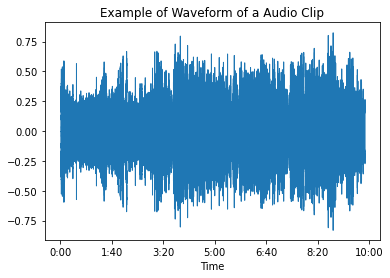

In [10]:
librosa.display.waveshow(signal1, sr=sr)
plt.title('Example of Waveform of a Audio Clip')
plt.show()

In [11]:
def test_threshold(src_root='to_split', threshold=0.05):
    
    wav_paths = glob.glob(src_root + '/*.wav')
    
    if len(wav_paths) == 0:
        print('audio file not found for sub-string')
        return
    
    wav, rate = librosa.load(wav_paths[0])
    mask, env = envelope(wav, rate, threshold=threshold)
    plt.style.use('ggplot')
    plt.title('Signal Envelope, Threshold = {}'.format(str(threshold)))
    plt.plot(wav[np.logical_not(mask)], color='r', label='remove')
    plt.plot(wav[mask], color='c', label='keep')
    plt.plot(env, color='m', label='envelope')
    plt.grid(False)
    plt.legend(loc='best')
    plt.show()

def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/20),
                       min_periods=1,
                       center=True).max()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean

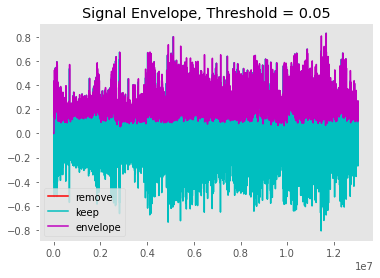

In [12]:
test_threshold()

From the graph, we can concur that the audio that we are classfying has a very low amplitude thus we conclude that the threshold of 0.05 is sufficient.

#### Splitting Audio Files to 1-Second Clip

After threshold has been identified, we will be splitting the audio files to 1-second audio clips which would be the same as per our existing dataset for consistency. The 1-second audio clips will be saved in a different folder of `clean`

In [15]:
def save_sample(sample, rate, target_dir, fn, ix):
    fn = fn.split('.wav')[0]
    dst_path = os.path.join(target_dir.split('.')[0], fn+'_{}.wav'.format(str(ix)))
    if os.path.exists(dst_path):
        return
    wavfile.write(dst_path, rate, sample)


def check_dir(path):
    if os.path.exists(path) is False:
        os.mkdir(path)


def split_wavs(src_root='to_split', dst_root='clean', dt=1.0, threshold=0.05):

    wav_paths = glob.glob(src_root + '/*.wav')
    
    # dirs = os.listdir(src_root)
    check_dir(dst_root)
    # classes = os.listdir(src_root)
    
    for file in tqdm(wav_paths):
        fn = file.split('\\')[1]
        wav, rate = librosa.load(file)
        mask, y_mean = envelope(wav, rate, threshold=threshold)
        wav = wav[mask]
        delta_sample = int(dt*rate)

        # cleaned audio is less than a single sample
        # pad with zeros to delta_sample size
        if wav.shape[0] < delta_sample:
            sample = np.zeros(shape=(delta_sample,), dtype=np.int16)
            sample[:wav.shape[0]] = wav
            save_sample(sample, rate, dst_root, fn, 0)
        # step through audio and save every delta_sample
        # discard the ending audio if it is too short
        else:
            trunc = wav.shape[0] % delta_sample
            for cnt, i in tqdm(enumerate(np.arange(0, wav.shape[0]-trunc, delta_sample)), desc='Progress Spliting'):
                start = int(i)
                stop = int(i + delta_sample)
                sample = wav[start:stop]
                save_sample(sample, rate, dst_root, fn, cnt)

In [16]:
split_wavs()

  0%|          | 0/8 [00:00<?, ?it/s]
Progress Spliting: 0it [00:00, ?it/s]
Progress Spliting: 590it [00:00, 3404.35it/s]
 12%|█▎        | 1/8 [01:14<08:43, 74.74s/it]
Progress Spliting: 0it [00:00, ?it/s]
Progress Spliting: 291it [00:00, 2364.78it/s]
 25%|██▌       | 2/8 [01:57<05:35, 55.97s/it]
Progress Spliting: 286it [00:00, 2866.80it/s]
 38%|███▊      | 3/8 [02:40<04:09, 49.83s/it]
Progress Spliting: 283it [00:00, 3147.28it/s]
 50%|█████     | 4/8 [03:21<03:06, 46.70s/it]
Progress Spliting: 285it [00:00, 3409.68it/s]
 62%|██████▎   | 5/8 [04:04<02:15, 45.04s/it]
Progress Spliting: 0it [00:00, ?it/s]
Progress Spliting: 404it [00:00, 3245.49it/s]
 88%|████████▊ | 7/8 [04:59<00:33, 33.22s/it]
Progress Spliting: 0it [00:00, ?it/s]
Progress Spliting: 575it [00:00, 3128.75it/s]
100%|██████████| 8/8 [06:13<00:00, 46.65s/it]


In [17]:
wav_paths = pd.DataFrame(glob.glob('clean' + '/*.wav'), columns=['filename'])
wav_paths['filename'] =  wav_paths['filename'].str.replace('\\','/', regex=True)
wav_paths

,filename
0,clean/130_Bus_0.wav
1,clean/130_Bus_1.wav
2,clean/130_Bus_10.wav
3,clean/130_Bus_100.wav
4,clean/130_Bus_101.wav
...,...
2710,clean/NEL-MRT_95.wav
2711,clean/NEL-MRT_96.wav
2712,clean/NEL-MRT_97.wav
2713,clean/NEL-MRT_98.wav


#### Adding Label for the audio clips

We will be also providing the label of the audio as per below for the modelling at later stage

In [18]:
label_dict = {'bus': 'bus',
              'mrt': 'metro',
              'cafe': 'cafe'
             }

def LabelData(filedir):
    for text,label in label_dict.items():
        if text in filedir.lower():
            return label
    return None

In [19]:
wav_paths['scene_label'] = wav_paths['filename'].apply(LabelData)
wav_paths.head(15)

,filename,scene_label
0,clean/130_Bus_0.wav,bus
1,clean/130_Bus_1.wav,bus
2,clean/130_Bus_10.wav,bus
3,clean/130_Bus_100.wav,bus
4,clean/130_Bus_101.wav,bus
5,clean/130_Bus_102.wav,bus
6,clean/130_Bus_103.wav,bus
7,clean/130_Bus_104.wav,bus
8,clean/130_Bus_105.wav,bus
9,clean/130_Bus_106.wav,bus


#### Merge the Two Dataframes

After the labelling, we will be concatting both dataframes that we have

In [20]:
df_train = pd.concat([df_train, wav_paths], ignore_index=True)

In [21]:
df_train

,filename,scene_label,log_melspectrogram
0,audio/bus-lyon-1001-40001-0-a.wav,bus,NaN
1,audio/bus-lyon-1001-40001-1-a.wav,bus,NaN
2,audio/bus-lyon-1001-40001-2-a.wav,bus,NaN
3,audio/bus-lyon-1001-40001-3-a.wav,bus,NaN
4,audio/bus-lyon-1001-40001-4-a.wav,bus,NaN
...,...,...,...
58950,clean/NEL-MRT_95.wav,metro,NaN
58951,clean/NEL-MRT_96.wav,metro,NaN
58952,clean/NEL-MRT_97.wav,metro,NaN
58953,clean/NEL-MRT_98.wav,metro,NaN


### Calculating Mel-Spectrogram

This project requires the audio to be transformed to Mel-Spectrogram instead of waveform in order for the model to make a better classification. Below is the example of how we extract mel-spectrogram from an audio.

#### Sample of Extracting Mel Spectrogram

**1. Load audio file**

In [22]:
audio = df_train['filename'][0]
audio

'audio/bus-lyon-1001-40001-0-a.wav'

In [23]:
# obtain the signal value and sampling rate
signal, sr = librosa.load(audio)

In [24]:
# sampling rate will be 22050 which the default for librosa.load function
sr 

22050

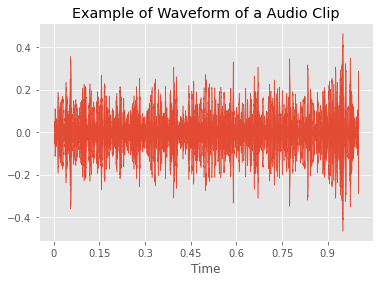

In [25]:
librosa.display.waveshow(signal, sr=sr)
plt.title('Example of Waveform of a Audio Clip')
plt.show()

Above is a sample of a waveform of an audio clip which is a common type of representation of audio. But with the waveform, it does not represent the distinct feature of the audio.

In [26]:
# sample of the audio
Audio(audio)

**2. Obtain the Mel Spectrogram**

Enter Spectrogram. A spectrogram is a graph that visually representing signal strength or 'loudness' with regards to time at various frequencies. In this project Mel-Spectrogram is used. Mel-Spectrogram is a spectrogram that is converted to a Mel Scale. Mel Scale imitates the human ear perceives audio signal, since humans do not perceive frequencies on a linear scale, where lower frequencies are easier to be detected than higher frequencies.

In [27]:
# obtain the mel spectrogram with the following settings
mel_spectrogram = librosa.feature.melspectrogram(signal, sr=sr, n_fft=2048, hop_length=512, n_mels=40)

C:\Users\Adi H. Kusuma\AppData\Local\Temp\ipykernel_15892\3620333921.py:2: FutureWarning: Pass y=[ 0.0376022   0.05205223  0.04018687 ... -0.27055785 -0.26379555
 -0.28815186] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spectrogram = librosa.feature.melspectrogram(signal, sr=sr, n_fft=2048, hop_length=512, n_mels=40)


In [28]:
mel_spectrogram.shape

(40, 44)

The shape represent how the spectrogram is formed. The first feature is the number of mels that we have chosen, which practically groups a range of frequencies for better visualisation. Meanwhile, the second feature represent the windows of the time that the spectrogram has created. In our case, we have 40 number of mels and 44 windows which is represented as blocks in the graph below.

C:\Users\Adi H. Kusuma\AppData\Local\Temp\ipykernel_15892\2499475497.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(format='%+2.f')


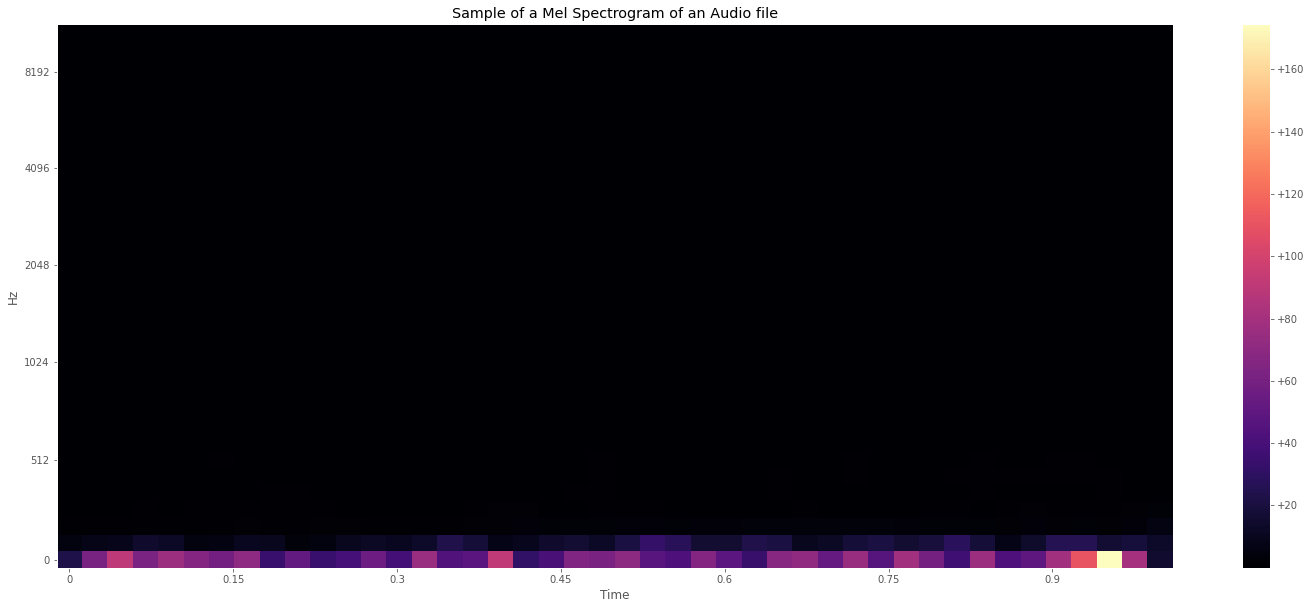

In [29]:
plt.figure(figsize=(25,10))
librosa.display.specshow(mel_spectrogram,
                        x_axis='time',
                        y_axis='mel',
                        sr=sr)
plt.colorbar(format='%+2.f')
plt.title('Sample of a Mel Spectrogram of an Audio file')
plt.show()

**3. Change the scale to dB(decibel) scale** 

Notice that the graph above has only little information at a lower frequencies, this is due to most of the audio that human might be able to perceives have lower frequency. Thus we need to change the frequency to a decibel scale which help to smoothen the frequency.

In [30]:
# smoothen the spectrogram into a dB scale
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
log_mel_spectrogram.shape

(40, 44)

C:\Users\Adi H. Kusuma\AppData\Local\Temp\ipykernel_15892\512873744.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(format='%+2.f')


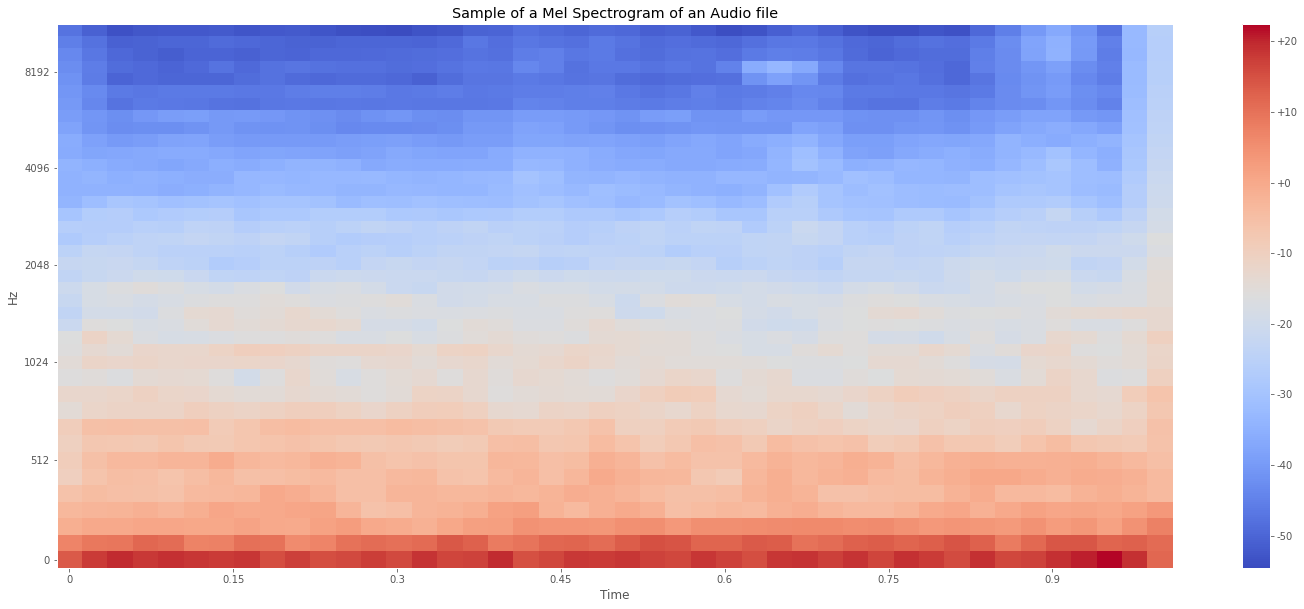

In [31]:
plt.figure(figsize=(25,10))
librosa.display.specshow(log_mel_spectrogram,
                        x_axis='time',
                        y_axis='mel',
                        sr=sr)
plt.colorbar(format='%+2.f')
plt.title('Sample of a Mel Spectrogram of an Audio file')
plt.show()

After converting it to a decibel scale, now we have a better representation of the audio which is able to be used for the model input.

#### Calculating Mel Spectrogram for every Audio Files

Next, we need to capture every audio files Mel-Spectrogram for the modelling input.

In [32]:
def MelSpectrogram(i):
    #obtain audio file path
    AUDIO_FILE = df_train['filename'].iloc[i]
    
    #load audio file
    signal, sr = librosa.load(AUDIO_FILE)
    
    #obtain mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(signal, sr=sr, n_fft=2048, hop_length=512, n_mels=40)
    
    #change to dB scale
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    return log_mel_spectrogram.T

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in tqdm(df_train.index, desc='Progress'):
        if type(df_train['log_melspectrogram'].iloc[i]) is not np.ndarray:
            df_train['log_melspectrogram'].iloc[i] = MelSpectrogram(i)

Progress: 100%|██████████| 58955/58955 [1:33:52<00:00, 10.47it/s]  


In [34]:
df_train

,filename,scene_label,log_melspectrogram
0,audio/bus-lyon-1001-40001-0-a.wav,bus,"[[13.577272, 7.025728, -1.2618985, -3.4342742,..."
1,audio/bus-lyon-1001-40001-1-a.wav,bus,"[[17.600836, 14.177676, 6.091573, 0.81835246, ..."
2,audio/bus-lyon-1001-40001-2-a.wav,bus,"[[18.510744, 16.79232, 11.121583, 1.0732065, -..."
3,audio/bus-lyon-1001-40001-3-a.wav,bus,"[[20.518055, 6.3174534, 4.113715, -3.8069892, ..."
4,audio/bus-lyon-1001-40001-4-a.wav,bus,"[[19.71752, 11.698871, 5.590608, 2.1607356, 0...."
...,...,...,...
58950,clean/NEL-MRT_95.wav,metro,"[[6.318292, 2.3621132, -5.236124, -9.880425, -..."
58951,clean/NEL-MRT_96.wav,metro,"[[10.197929, 9.166535, 3.6991322, 4.068353, -4..."
58952,clean/NEL-MRT_97.wav,metro,"[[11.002901, 10.734147, 0.834878, 0.38001227, ..."
58953,clean/NEL-MRT_98.wav,metro,"[[10.103996, 11.94078, 7.0030684, 3.9187765, 2..."


In [35]:
df_train['scene_label'].value_counts()

bus               14994
metro             14395
park              14290
street_traffic    14130
cafe               1146
Name: scene_label, dtype: int64

Based on the list above, we can infer that our dataset is quite balanced, besides the cafe scene. Thus, we would remove the cafe out from the dataset.

In [36]:
df_train[df_train['scene_label'] != 'cafe']

,filename,scene_label,log_melspectrogram
0,audio/bus-lyon-1001-40001-0-a.wav,bus,"[[13.577272, 7.025728, -1.2618985, -3.4342742,..."
1,audio/bus-lyon-1001-40001-1-a.wav,bus,"[[17.600836, 14.177676, 6.091573, 0.81835246, ..."
2,audio/bus-lyon-1001-40001-2-a.wav,bus,"[[18.510744, 16.79232, 11.121583, 1.0732065, -..."
3,audio/bus-lyon-1001-40001-3-a.wav,bus,"[[20.518055, 6.3174534, 4.113715, -3.8069892, ..."
4,audio/bus-lyon-1001-40001-4-a.wav,bus,"[[19.71752, 11.698871, 5.590608, 2.1607356, 0...."
...,...,...,...
58950,clean/NEL-MRT_95.wav,metro,"[[6.318292, 2.3621132, -5.236124, -9.880425, -..."
58951,clean/NEL-MRT_96.wav,metro,"[[10.197929, 9.166535, 3.6991322, 4.068353, -4..."
58952,clean/NEL-MRT_97.wav,metro,"[[11.002901, 10.734147, 0.834878, 0.38001227, ..."
58953,clean/NEL-MRT_98.wav,metro,"[[10.103996, 11.94078, 7.0030684, 3.9187765, 2..."


Finally, we will save the dataframe with pickle to help retain all the attributes within the dataframe for further use in another notebook.

In [37]:
pickle.dump(df_train, open('csv/clean_data.df','wb'))

This is the end of the first notebook. The modelling part will be shown in the next notebook.